In [52]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [53]:
df = pd.read_csv('AAPL.csv')


In [54]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [55]:
df.shape

(251, 7)

In [56]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
train_dates.tail(15)

236   2023-06-20
237   2023-06-21
238   2023-06-22
239   2023-06-23
240   2023-06-26
241   2023-06-27
242   2023-06-28
243   2023-06-29
244   2023-06-30
245   2023-07-03
246   2023-07-05
247   2023-07-06
248   2023-07-07
249   2023-07-10
250   2023-07-11
Name: Date, dtype: datetime64[ns]

In [57]:
cols = list(df)[1:6]
#Date and volume columns are not used in training.
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [58]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [59]:
import joblib

In [60]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [61]:
trainX = []
trainY = []

n_future = 1
n_past = 14

In [62]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

In [63]:
trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (237, 14, 5).
trainY shape == (237, 1).


In [64]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
14/14 [==============================] - 6s 78ms/step - loss: 0.3941 - val_loss: 0.7404
Epoch 2/5
14/14 [==============================] - 1s 42ms/step - loss: 0.1609 - val_loss: 3.0636
Epoch 3/5
14/14 [==============================] - 1s 37ms/step - loss: 0.1290 - val_loss: 0.2018
Epoch 4/5
14/14 [==============================] - 1s 37ms/step - loss: 0.1122 - val_loss: 0.1617
Epoch 5/5
14/14 [==============================] - 0s 24ms/step - loss: 0.0870 - val_loss: 0.2238


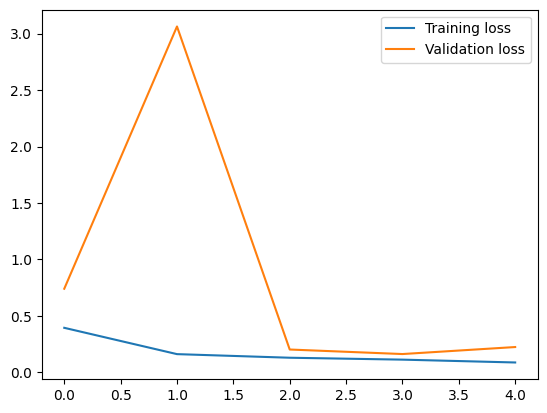

In [66]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [67]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay


In [68]:
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [69]:
n_past = 0
n_days_for_prediction=15

In [70]:
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

# Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:])

[Timestamp('2022-07-12 00:00:00', freq='C'), Timestamp('2022-07-13 00:00:00', freq='C'), Timestamp('2022-07-14 00:00:00', freq='C'), Timestamp('2022-07-15 00:00:00', freq='C'), Timestamp('2022-07-18 00:00:00', freq='C'), Timestamp('2022-07-19 00:00:00', freq='C'), Timestamp('2022-07-20 00:00:00', freq='C'), Timestamp('2022-07-21 00:00:00', freq='C'), Timestamp('2022-07-22 00:00:00', freq='C'), Timestamp('2022-07-25 00:00:00', freq='C'), Timestamp('2022-07-26 00:00:00', freq='C'), Timestamp('2022-07-27 00:00:00', freq='C'), Timestamp('2022-07-28 00:00:00', freq='C'), Timestamp('2022-07-29 00:00:00', freq='C'), Timestamp('2022-08-01 00:00:00', freq='C')]
1/1 [==============================] - 0s 343ms/step


In [71]:
predict_period_dates = pd.date_range(list(train_dates)[n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

In [72]:
prediction = model.predict(trainX[-n_days_for_prediction:])
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


1/1 [==============================] - 0s 30ms/step


In [73]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

In [74]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

<ipython-input-74-023fd395994a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Axes: >

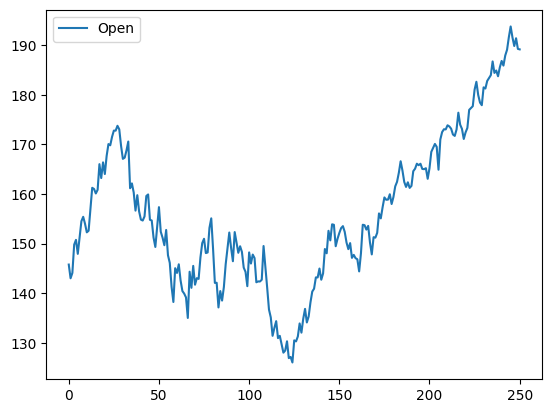

In [75]:
sns.lineplot([original['Date'], original['Open']])


<Axes: >

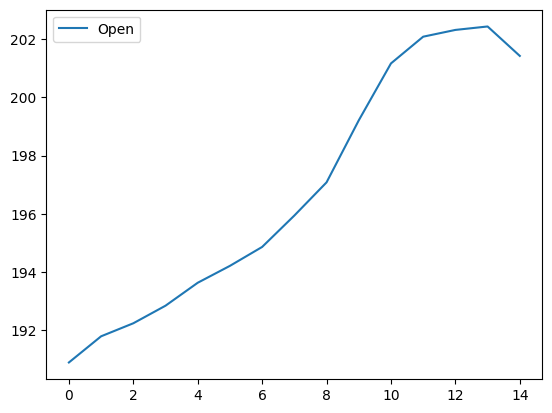

In [76]:
sns.lineplot([df_forecast['Date'], df_forecast['Open']])

In [77]:
model.save('my_model.h5')

In [80]:
# Assuming 'model' is your trained model
model.save_weights('my_model_weights.h5')


In [79]:
original.tail()

,Date,Open
246,2023-07-05,191.570007
247,2023-07-06,189.839996
248,2023-07-07,191.410004
249,2023-07-10,189.259995
250,2023-07-11,189.160004
